In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
    lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(4)])
    ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
                   lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([LinearChol(dim=dim[0]*dim[1], name='lc', aux_vars=aux_vars)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice_2:0' shape=(1, 20, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
df = dim[0]*dim[1]
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [20]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [21]:
sess = tf.InteractiveSession()

In [22]:
tf.global_variables_initializer().run()

In [23]:
prior.eval(), ent.eval(), logl.eval()

(-130351.13280021328, 701.7622323724445, -14985.702428661696)

In [24]:
loss.eval()

array([110.80350919])

In [25]:
np.set_printoptions(precision=4)

In [26]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.5711e+04,  6.3079e+01,  5.6103e+01],
       [ 6.3079e+01,  8.2220e+04, -2.2680e+02],
       [ 5.6103e+01, -2.2680e+02,  2.5177e+02]])

In [27]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [132]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

[2.7177]
[[ 1562.4741   193.4562   280.3516]
 [  193.4562  2675.5145  -835.9933]
 [  280.3516  -835.9933 28374.4152]]


[2.6911]
[[  925.1241   159.9134  1649.236 ]
 [  159.9134  6653.6951 -5784.8988]
 [ 1649.236  -5784.8988 38141.8089]]


[2.6995]
[[ 1042.6153   212.1377   410.5171]
 [  212.1377  3919.7477 -2580.1075]
 [  410.5171 -2580.1075 26448.7282]]


[2.7507]
[[ 1929.8981   715.7787  -547.384 ]
 [  715.7787  4221.6818   519.6476]
 [ -547.384    519.6476 25141.7246]]


[2.7967]
[[ 1333.542   -232.2282 -1603.9295]
 [ -232.2282  4169.6848  -478.8947]
 [-1603.9295  -478.8947 14874.398 ]]


[2.7363]
[[  745.0243  -114.8878  3262.4787]
 [ -114.8878  8018.6728   291.0208]
 [ 3262.4787   291.0208 40198.8207]]


[2.7447]
[[  601.2484  -759.8715   -46.6319]
 [ -759.8715  6375.8246   180.9859]
 [  -46.6319   180.9859 25389.7602]]


[2.7469]
[[  616.6253   197.2136  -915.9907]
 [  197.2136  6818.5987   926.3486]
 [ -915.9907   926.3486 23302.9149]]


[2.6885]
[[ 1140.2655  -628.7199   313.6

[2.677]
[[ 1123.7944  -698.2654   250.4635]
 [ -698.2654  4966.2979  -895.6078]
 [  250.4635  -895.6078 17884.8593]]


[2.7281]
[[  966.9459  -385.1201  -206.2647]
 [ -385.1201  6589.7693   615.4056]
 [ -206.2647   615.4056 36205.9088]]


[2.8079]
[[ 1221.7513  -277.3775 -1823.0335]
 [ -277.3775  5116.2005  1278.5821]
 [-1823.0335  1278.5821 31474.2203]]


[2.6692]
[[  876.8719   477.3768  1928.3122]
 [  477.3768  7409.3669 -3341.2054]
 [ 1928.3122 -3341.2054 52453.6745]]


[2.7092]
[[ 1055.6802  -843.4468  -241.4499]
 [ -843.4468 10278.5607   -89.0737]
 [ -241.4499   -89.0737 40811.5518]]


[2.973]
[[ 1.0162e+03 -7.5453e+00  2.0369e+03]
 [-7.5453e+00  1.1109e+04 -1.7909e+03]
 [ 2.0369e+03 -1.7909e+03  2.6400e+04]]


[2.6509]
[[ 1439.5148  -146.9017 -1474.9457]
 [ -146.9017  6451.2202  1416.2855]
 [-1474.9457  1416.2855 26079.6574]]


[2.6367]
[[  845.4279   -79.4727  1841.4167]
 [  -79.4727  5110.5117 -3444.8931]
 [ 1841.4167 -3444.8931 48804.8361]]


[2.7542]
[[ 1002.5294   530.8463 

[2.7763]
[[ 1119.2288  2065.7187  -435.9655]
 [ 2065.7187  8521.7069  1868.745 ]
 [ -435.9655  1868.745  27298.1834]]


[2.7535]
[[  697.515   -866.1984  -152.3211]
 [ -866.1984  7457.1544 -4639.7986]
 [ -152.3211 -4639.7986 45915.9028]]


[2.7928]
[[  549.0972  -603.1825  1419.7271]
 [ -603.1825  9666.783  -1326.547 ]
 [ 1419.7271 -1326.547  24859.5159]]


[2.7208]
[[ 1302.2946   -56.4221 -1695.5714]
 [  -56.4221  6929.9999  5370.7701]
 [-1695.5714  5370.7701 29484.5663]]


[2.6655]
[[  890.023   -339.5041    96.4289]
 [ -339.5041  5114.9986  4904.0617]
 [   96.4289  4904.0617 27221.1749]]


[3.0527]
[[  871.2043  -340.4347  -796.014 ]
 [ -340.4347  4142.687  -6065.5271]
 [ -796.014  -6065.5271 39246.3938]]


[2.6732]
[[  753.4813  -887.9909   303.4627]
 [ -887.9909  4172.4052   745.4842]
 [  303.4627   745.4842 21062.1662]]


[3.0395]
[[ 1141.1031  -378.5035   432.472 ]
 [ -378.5035  5573.0405  1208.9695]
 [  432.472   1208.9695 37423.4337]]


[2.7302]
[[  790.545    756.051   1432.1

[2.6849]
[[  907.1542   743.7132  1973.7149]
 [  743.7132 10951.1547 -1259.5985]
 [ 1973.7149 -1259.5985 50071.6566]]


[2.6426]
[[ 1274.5932  1231.3167   425.1332]
 [ 1231.3167 16636.9786  4237.1349]
 [  425.1332  4237.1349 35351.7758]]


[2.6553]
[[ 1477.2179   304.619   2682.0518]
 [  304.619   6649.8236  1377.1741]
 [ 2682.0518  1377.1741 38106.128 ]]


[2.7635]
[[ 1041.2441  -512.834  -1878.6159]
 [ -512.834   7716.1401 -7731.7806]
 [-1878.6159 -7731.7806 53031.6898]]


[2.68]
[[  654.3691  -489.5088  2150.7299]
 [ -489.5088  4727.5106 -1517.3435]
 [ 2150.7299 -1517.3435 40006.4239]]


[2.6841]
[[  864.5872   792.3234 -1867.4114]
 [  792.3234  8096.2029  -448.4011]
 [-1867.4114  -448.4011 39827.6836]]


[2.7276]
[[  774.2074  -647.8224  -133.5849]
 [ -647.8224  6562.3474  -943.7579]
 [ -133.5849  -943.7579 47251.0311]]


[2.7149]
[[ 1682.1592  -966.3503  2079.7512]
 [ -966.3503  6171.6045 -2004.6811]
 [ 2079.7512 -2004.6811 35383.9063]]


[2.7015]
[[  684.686    207.5913   582.494

[2.6832]
[[ 1038.7393  -272.0127 -1353.013 ]
 [ -272.0127  9206.354    522.6723]
 [-1353.013    522.6723 18419.5428]]


[2.8417]
[[ 1162.2925  -220.6841  -354.731 ]
 [ -220.6841  5289.0744    73.1297]
 [ -354.731     73.1297 27194.6956]]


[2.7895]
[[  855.0702  -576.8136 -1898.3155]
 [ -576.8136  4397.0452  1432.0915]
 [-1898.3155  1432.0915 29972.2719]]


[2.7517]
[[  622.9043 -1074.7885   198.8009]
 [-1074.7885  7438.3098 -3254.9848]
 [  198.8009 -3254.9848 79261.5063]]


[3.0236]
[[ 1639.7529  -898.5495  -195.3165]
 [ -898.5495  7939.5701  2425.3139]
 [ -195.3165  2425.3139 40971.7486]]


[2.7335]
[[  589.5503  -882.184   -775.7984]
 [ -882.184   9489.1266   545.1151]
 [ -775.7984   545.1151 80488.6296]]


[2.6549]
[[ 1047.1339  -677.8189 -1614.831 ]
 [ -677.8189  5293.2219 -3812.4845]
 [-1614.831  -3812.4845 32379.6696]]


[2.6479]
[[  950.6138   432.691    413.4158]
 [  432.691  11445.8102 -8028.552 ]
 [  413.4158 -8028.552  26098.1934]]


[2.749]
[[  705.3315  -646.1766   252.69

[2.7208]
[[ 1390.6454   -90.5367  -822.2909]
 [  -90.5367  5345.3128   168.5447]
 [ -822.2909   168.5447 37728.9038]]


[2.7513]
[[  701.2385   404.9195  1072.0479]
 [  404.9195  9169.88   -4401.8565]
 [ 1072.0479 -4401.8565 43417.564 ]]


[2.682]
[[  738.2897  -362.3657 -2100.1137]
 [ -362.3657  5728.0611  -276.7262]
 [-2100.1137  -276.7262 55701.2623]]


[2.7312]
[[ 2086.6678  -339.5951  -117.3001]
 [ -339.5951  6342.0671  1847.1504]
 [ -117.3001  1847.1504 63942.8079]]


[2.7632]
[[ 8.4309e+02 -6.0954e+01 -2.1678e+01]
 [-6.0954e+01  1.3886e+04 -1.2772e+03]
 [-2.1678e+01 -1.2772e+03  3.1144e+04]]


[2.7]
[[ 1471.0204   -77.8134  1409.9204]
 [  -77.8134  5853.3186   777.7558]
 [ 1409.9204   777.7558 41190.9491]]


[2.7883]
[[  810.6805  -427.5586 -1424.3089]
 [ -427.5586  4654.6489 -1688.7326]
 [-1424.3089 -1688.7326 67479.0407]]


[2.8829]
[[ 1345.0409   299.1041 -1360.2704]
 [  299.1041  7611.6696 -1215.2942]
 [-1360.2704 -1215.2942 49621.3804]]


[2.6482]
[[  640.2654  -147.8704  -

[2.7583]
[[ 1129.8472  -217.4067  -407.3207]
 [ -217.4067  7506.0427  3788.0944]
 [ -407.3207  3788.0944 25543.4273]]


[2.7713]
[[ 1213.3722   923.631   -815.6879]
 [  923.631   5380.5593 -3804.4925]
 [ -815.6879 -3804.4925 39817.3315]]


[2.7272]
[[ 1038.5279   351.2061  -509.7831]
 [  351.2061  7584.6123  2221.5367]
 [ -509.7831  2221.5367 47883.2714]]


[2.741]
[[ 1669.8995 -1686.027  -3193.1324]
 [-1686.027  17967.4807  2721.0629]
 [-3193.1324  2721.0629 46359.0036]]


[2.6643]
[[  637.9057   586.8432   704.0288]
 [  586.8432  6414.2607   294.8646]
 [  704.0288   294.8646 23959.3967]]


[2.6766]
[[  969.5767  -180.0514  1597.5714]
 [ -180.0514  5515.0828   485.044 ]
 [ 1597.5714   485.044  44099.5207]]


[2.8245]
[[ 1342.4245  -607.6847    44.928 ]
 [ -607.6847  6242.1725  2204.1423]
 [   44.928   2204.1423 31473.0747]]


[3.0369]
[[  781.1016  -445.7834   359.0646]
 [ -445.7834  3472.6616 -2107.9126]
 [  359.0646 -2107.9126 27950.9751]]


[2.7226]
[[ 2376.7148   -71.3394  4876.03

[2.7609]
[[ 1431.1596   377.8284 -1226.3156]
 [  377.8284  7128.0971   185.694 ]
 [-1226.3156   185.694  89986.4376]]


[2.7893]
[[ 1085.4649  -404.7243  3395.8756]
 [ -404.7243  8340.6982 -3221.833 ]
 [ 3395.8756 -3221.833  47176.065 ]]


[2.6456]
[[ 1173.1171   831.9576  1221.8817]
 [  831.9576  5751.9171 -2467.9682]
 [ 1221.8817 -2467.9682 69406.5689]]


[2.6941]
[[ 1031.8752  -809.3282  2180.3111]
 [ -809.3282  7306.5079   429.1142]
 [ 2180.3111   429.1142 33006.8469]]


[2.7124]
[[  867.0479   640.7791   415.2797]
 [  640.7791  5465.7492  5208.857 ]
 [  415.2797  5208.857  34487.3085]]


[2.7138]
[[ 1206.633    -85.0393 -1128.3976]
 [  -85.0393  5640.4484 -2440.6655]
 [-1128.3976 -2440.6655 75223.5388]]


[2.6972]
[[ 2.0149e+03 -1.0127e+03  8.8308e+02]
 [-1.0127e+03  1.0536e+04 -2.5061e+00]
 [ 8.8308e+02 -2.5061e+00  3.6327e+04]]


[2.7069]
[[ 1044.249    304.2345  1940.4085]
 [  304.2345 10631.7518  7708.0877]
 [ 1940.4085  7708.0877 61275.0953]]


[2.968]
[[ 4.1499e+02  5.8271e+

[2.6544]
[[  979.9945   225.2291 -1618.9639]
 [  225.2291  6144.5943  3898.0719]
 [-1618.9639  3898.0719 39660.9672]]


[2.7233]
[[  597.7637   634.1964  2082.2122]
 [  634.1964  8574.1739  1281.544 ]
 [ 2082.2122  1281.544  41268.0619]]


[2.7122]
[[ 1781.3295   588.4582   517.8046]
 [  588.4582 11621.4206 11725.7903]
 [  517.8046 11725.7903 43140.972 ]]


[2.7292]
[[  300.5671  -112.5451   703.1876]
 [ -112.5451 13909.6267  5929.8815]
 [  703.1876  5929.8815 30985.72  ]]


[3.0549]
[[  586.9367  -754.0898  1168.9393]
 [ -754.0898  9033.6928 -2161.879 ]
 [ 1168.9393 -2161.879  30377.568 ]]


[2.6718]
[[ 1890.3802  -420.4397  1091.6498]
 [ -420.4397  8212.1149  5257.2289]
 [ 1091.6498  5257.2289 71991.1674]]


[2.752]
[[  958.9437  -785.4186  -422.7833]
 [ -785.4186  5340.1318 -1074.8937]
 [ -422.7833 -1074.8937 23443.4618]]


[2.6264]
[[ 1102.0175   841.323  -2139.38  ]
 [  841.323   6790.6062   645.8114]
 [-2139.38     645.8114 40262.9668]]


[2.8553]
[[ 1193.0785   662.9232  -320.20

[2.6613]
[[  978.9242  -126.6316  -486.7125]
 [ -126.6316  5725.938   1956.2999]
 [ -486.7125  1956.2999 50923.1678]]


[2.7453]
[[ 1251.0849  -638.8805   375.167 ]
 [ -638.8805  7266.8208 -1497.021 ]
 [  375.167  -1497.021  41587.0394]]


[2.7631]
[[ 2286.1803  -515.5033 -1191.0322]
 [ -515.5033  7721.7929  2278.1954]
 [-1191.0322  2278.1954 43215.7141]]


[2.7454]
[[ 1220.3965   744.9319   755.6728]
 [  744.9319  8286.7296 -3812.9256]
 [  755.6728 -3812.9256 60925.5582]]


[2.6471]
[[ 1041.4232   -78.549   -970.1302]
 [  -78.549   5723.8064   -68.7847]
 [ -970.1302   -68.7847 67659.3516]]


[3.0792]
[[  650.1543  -131.9292   332.934 ]
 [ -131.9292  4209.1843 -1206.6479]
 [  332.934  -1206.6479 24074.491 ]]


[2.7635]
[[  736.1834   689.3105  2974.7858]
 [  689.3105  7357.7417 15419.1194]
 [ 2974.7858 15419.1194 61550.8129]]


[2.7266]
[[ 1468.9991  1062.0451   705.6729]
 [ 1062.0451  6938.4251  3344.756 ]
 [  705.6729  3344.756  41840.2356]]


[2.7459]
[[ 2.0823e+03  7.2760e+02  3.95

[2.7043]
[[  902.4422   293.4458  -400.422 ]
 [  293.4458  5037.2522  2744.9967]
 [ -400.422   2744.9967 49011.2956]]


[2.683]
[[ 1285.4945   -39.4332 -2369.286 ]
 [  -39.4332 11539.2296 -4822.4786]
 [-2369.286  -4822.4786 36719.3882]]


[3.0349]
[[ 1557.8663   527.5049  1293.1205]
 [  527.5049  6543.1231  2751.189 ]
 [ 1293.1205  2751.189  29883.6634]]


[2.7323]
[[  857.0295   835.3551 -2226.3882]
 [  835.3551  6136.628   -184.4741]
 [-2226.3882  -184.4741 46294.2976]]


[2.6734]
[[ 2121.6968   445.2316 -3691.1509]
 [  445.2316  9583.9001 -2441.437 ]
 [-3691.1509 -2441.437  53812.0979]]


[2.7544]
[[ 1240.3449  -393.393  -1394.8003]
 [ -393.393   6827.3219  3897.0736]
 [-1394.8003  3897.0736 44642.408 ]]


[2.6911]
[[ 1056.2318   441.4174  2413.671 ]
 [  441.4174  6397.0795 -3299.5815]
 [ 2413.671  -3299.5815 41552.8849]]


[2.7635]
[[ 1870.2439  -862.2264 -2804.317 ]
 [ -862.2264  7572.8223 -1961.6439]
 [-2804.317  -1961.6439 27923.2982]]


[2.6493]
[[ 1225.5639  -682.2924 -1514.15

[2.7337]
[[ 1064.3668  -230.5221   172.1786]
 [ -230.5221  8630.6738 -4528.8533]
 [  172.1786 -4528.8533 52916.7888]]


[2.6159]
[[ 1258.0292  -285.4896 -2630.4311]
 [ -285.4896  6432.9203   481.3446]
 [-2630.4311   481.3446 42217.0883]]


[2.7791]
[[ 1.1281e+03 -1.1503e+03 -3.4229e+03]
 [-1.1503e+03  6.8672e+03  2.6462e+01]
 [-3.4229e+03  2.6462e+01  6.7627e+04]]


[2.6812]
[[ 1080.2967  1148.7665  3961.5065]
 [ 1148.7665 11533.9148  5446.9971]
 [ 3961.5065  5446.9971 75664.9634]]


[2.7148]
[[ 1325.6763   829.6403  4209.2299]
 [  829.6403  5478.6755  5501.642 ]
 [ 4209.2299  5501.642  88173.4379]]


[2.7318]
[[ 1199.6674  1162.5923  -942.8003]
 [ 1162.5923  4541.2738 -1177.1063]
 [ -942.8003 -1177.1063 26395.2573]]


[2.7117]
[[ 1200.3414  -249.7598  1726.9142]
 [ -249.7598 11579.2894  4566.2636]
 [ 1726.9142  4566.2636 56016.5828]]


[2.7012]
[[  977.6241   180.1512 -3618.2899]
 [  180.1512  6605.2735 -6093.5905]
 [-3618.2899 -6093.5905 64426.6074]]


[2.8082]
[[ 1897.7622  -259.050

[2.7074]
[[ 1304.7223 -1207.9462 -3562.4306]
 [-1207.9462  5240.6527  7589.0969]
 [-3562.4306  7589.0969 46843.3357]]


[2.7309]
[[  740.0067   121.3531 -1037.56  ]
 [  121.3531  5926.9867 -3841.6516]
 [-1037.56   -3841.6516 43967.9231]]


[2.7658]
[[  542.9995  1422.2236  1722.7893]
 [ 1422.2236  8536.4864 -1603.5604]
 [ 1722.7893 -1603.5604 59167.8402]]


[2.6419]
[[ 1239.1588  -175.0613  1925.9444]
 [ -175.0613 10467.4814 -9626.9697]
 [ 1925.9444 -9626.9697 94706.4574]]


[2.7376]
[[  1784.6306  -1744.477    1694.4201]
 [ -1744.477    9159.3986 -10475.8102]
 [  1694.4201 -10475.8102  54887.0455]]


[2.6785]
[[  903.1393   437.9452   535.9425]
 [  437.9452  9803.2641  -690.0415]
 [  535.9425  -690.0415 70081.059 ]]


[2.7486]
[[ 1108.2413  -674.5059  -612.9915]
 [ -674.5059  4325.8538  -654.6659]
 [ -612.9915  -654.6659 40052.555 ]]


[2.7064]
[[ 1243.1174  -280.7424  1521.4452]
 [ -280.7424 14411.164    243.3236]
 [ 1521.4452   243.3236 49063.4901]]


[3.0878]
[[  776.9745  -282.111

[2.7065]
[[  887.8685  -279.575   -408.8291]
 [ -279.575   9393.0182 -4650.7073]
 [ -408.8291 -4650.7073 42134.0594]]


[2.7359]
[[ 1.0820e+03 -6.3679e+02  4.5064e+01]
 [-6.3679e+02  5.2953e+03 -5.6568e+03]
 [ 4.5064e+01 -5.6568e+03  4.6282e+04]]


[2.803]
[[  846.9637   902.9384  -429.497 ]
 [  902.9384  8967.0615  5125.9483]
 [ -429.497   5125.9483 58711.1687]]


[2.7543]
[[ 2237.3656  -539.6374  -775.6137]
 [ -539.6374  4945.4062 -1905.0303]
 [ -775.6137 -1905.0303 72363.9523]]


[2.6936]
[[  766.5372   532.1591   550.417 ]
 [  532.1591  5256.6448 -2132.6463]
 [  550.417  -2132.6463 61883.2512]]


[2.723]
[[  943.9009  -330.8541   594.2574]
 [ -330.8541  5950.6746 -3618.7319]
 [  594.2574 -3618.7319 50168.6322]]


[2.6308]
[[  902.4776  -105.1319 -2378.0333]
 [ -105.1319  7412.3321  7583.8198]
 [-2378.0333  7583.8198 60274.4457]]


[2.6337]
[[  974.3203   841.3248  2397.2405]
 [  841.3248 12110.0263  2851.4087]
 [ 2397.2405  2851.4087 40806.6431]]


[2.7638]
[[1.0618e+03 1.6490e+01 

[2.7085]
[[ 1192.2503    71.5679  3885.4176]
 [   71.5679  6259.1109  7010.1874]
 [ 3885.4176  7010.1874 68045.9964]]


[2.7468]
[[ 1002.173    -88.0175 -1510.4277]
 [  -88.0175 10784.61   -4976.9579]
 [-1510.4277 -4976.9579 36509.3933]]


[2.6419]
[[  496.0785  -396.4731 -2196.8798]
 [ -396.4731  6588.1352  3515.3014]
 [-2196.8798  3515.3014 46599.9275]]


[2.6998]
[[  631.5734   302.0877  -316.2482]
 [  302.0877  8698.0616  -385.9283]
 [ -316.2482  -385.9283 53106.041 ]]


[2.6663]
[[ 1348.3325 -1047.9426   682.049 ]
 [-1047.9426  6351.1161 -6677.9016]
 [  682.049  -6677.9016 41447.9433]]


[2.7134]
[[ 1070.8053  -515.3918 -1885.488 ]
 [ -515.3918  6002.159  -2668.6162]
 [-1885.488  -2668.6162 59616.1498]]


[2.661]
[[ 1103.5191  -157.309   3062.1633]
 [ -157.309   8037.8261 -4370.2056]
 [ 3062.1633 -4370.2056 49492.2046]]


[2.7394]
[[ 1415.9144 -1166.5256   229.2467]
 [-1166.5256 13202.5501  1448.0983]
 [  229.2467  1448.0983 49539.4807]]


[2.6911]
[[ 1089.1587  -824.6133  -417.78

[2.7384]
[[   940.701     675.2096   2236.2977]
 [   675.2096   8069.6873  -5570.392 ]
 [  2236.2977  -5570.392  109816.0308]]


[2.6194]
[[ 1193.7592  -847.9686 -2097.6192]
 [ -847.9686 10728.8765  6177.835 ]
 [-2097.6192  6177.835  52227.5492]]


[2.6992]
[[ 1826.2603   637.4554  2192.36  ]
 [  637.4554  6828.1551   748.1473]
 [ 2192.36     748.1473 61709.1565]]


[2.6879]
[[ 1090.1116   774.5212   401.268 ]
 [  774.5212 12044.4482  4264.1048]
 [  401.268   4264.1048 51111.0492]]


[2.6826]
[[  660.0492  -127.6034  3543.86  ]
 [ -127.6034  6661.6988   226.7749]
 [ 3543.86     226.7749 67653.8748]]


[2.6729]
[[ 2059.7092  -538.8472   198.9144]
 [ -538.8472  8765.2483 -2269.5583]
 [  198.9144 -2269.5583 32322.3867]]


[2.7451]
[[  969.2812  -795.9416  -775.8802]
 [ -795.9416  7845.7181  6411.2907]
 [ -775.8802  6411.2907 44679.5203]]


[2.6996]
[[ 1407.3463  -400.9435  3373.6143]
 [ -400.9435  7871.852   3154.0287]
 [ 3373.6143  3154.0287 56546.3634]]


[2.8045]
[[ 1165.4454   702.881

[2.7219]
[[ 1711.461  -1475.5401 -4703.4514]
 [-1475.5401 19063.6756 -9384.2236]
 [-4703.4514 -9384.2236 70282.2499]]


[2.6502]
[[  417.4913  -564.8013  -621.3291]
 [ -564.8013 12272.6904   224.0506]
 [ -621.3291   224.0506 49824.0599]]


[2.6511]
[[ 1.1227e+03 -1.2239e+01  5.6025e+02]
 [-1.2239e+01  8.3722e+03  7.4596e+03]
 [ 5.6025e+02  7.4596e+03  7.8782e+04]]


[2.6616]
[[  727.9141  -820.4495  -186.556 ]
 [ -820.4495  9017.4425 -7890.4378]
 [ -186.556  -7890.4378 44760.5222]]


[2.7593]
[[ 1.3146e+03 -1.2657e+00 -1.4251e+03]
 [-1.2657e+00  8.6307e+03  1.9731e+03]
 [-1.4251e+03  1.9731e+03  6.3150e+04]]


[2.7007]
[[ 1758.5734   563.3042   -65.1245]
 [  563.3042 11875.0153  1656.7102]
 [  -65.1245  1656.7102 43389.0136]]


[2.7043]
[[ 1032.607    346.8842 -1759.7152]
 [  346.8842  7431.7862  4250.7586]
 [-1759.7152  4250.7586 53082.4487]]


[2.7016]
[[ 1.1364e+03  3.0204e+01 -2.3215e+03]
 [ 3.0204e+01  8.1309e+03 -1.2088e+03]
 [-2.3215e+03 -1.2088e+03  5.2080e+04]]


[2.6497]
[[ 1

[2.7279]
[[  737.9228  -641.1799 -2336.3096]
 [ -641.1799 10153.2284 -4092.0399]
 [-2336.3096 -4092.0399 51172.4286]]


[2.7599]
[[ 1.2520e+03 -1.7278e+01 -6.7941e+02]
 [-1.7278e+01  9.4812e+03  2.0667e+03]
 [-6.7941e+02  2.0667e+03  5.1643e+04]]


[2.7454]
[[ 1657.6177   -75.3616  1309.1439]
 [  -75.3616 10611.6295  7451.0066]
 [ 1309.1439  7451.0066 63148.4476]]


[2.6897]
[[ 1195.743   -123.1418   832.6397]
 [ -123.1418  9170.7162  1867.8257]
 [  832.6397  1867.8257 41896.1673]]


[2.6824]
[[ 1488.1207   924.0067   133.4118]
 [  924.0067 14876.2283 -4037.5032]
 [  133.4118 -4037.5032 56192.7793]]


[2.7452]
[[ 1474.2826   118.3829  1064.0287]
 [  118.3829 10253.2279   885.7638]
 [ 1064.0287   885.7638 79604.118 ]]


[2.7259]
[[  1609.2482    111.4256  -2029.1087]
 [   111.4256  13825.8161 -10173.4631]
 [ -2029.1087 -10173.4631  44272.5769]]


[2.6944]
[[ 1588.2149  -718.5102 -2383.0501]
 [ -718.5102 12391.4415   150.3421]
 [-2383.0501   150.3421 47784.0993]]


[2.7572]
[[ 1956.0551 

[2.6519]
[[  2163.5155   1885.2114  -5118.8858]
 [  1885.2114  11499.3016 -13213.1225]
 [ -5118.8858 -13213.1225  60872.2603]]


[2.6922]
[[ 1.2838e+03 -2.6861e+01  3.0058e+03]
 [-2.6861e+01  1.3503e+04 -1.0724e+04]
 [ 3.0058e+03 -1.0724e+04  5.2926e+04]]


[2.6339]
[[ 1.2472e+03 -5.8148e+01  2.6792e+02]
 [-5.8148e+01  1.2997e+04  6.9236e+03]
 [ 2.6792e+02  6.9236e+03  6.5905e+04]]


[2.7791]
[[ 1347.3923   -83.8395 -1914.8233]
 [  -83.8395 10620.0459 -5010.2034]
 [-1914.8233 -5010.2034 77199.3036]]


[2.7653]
[[  865.8161   -78.5022  -710.7021]
 [  -78.5022  6496.3074  5540.8322]
 [ -710.7021  5540.8322 64026.5004]]


[2.7154]
[[ 2169.814    527.5176  3809.8459]
 [  527.5176  4674.0774  -878.2994]
 [ 3809.8459  -878.2994 45879.7926]]


[2.7033]
[[  937.2204   -86.7715  1392.1774]
 [  -86.7715 11006.7071  6788.3508]
 [ 1392.1774  6788.3508 63138.8049]]


[2.7773]
[[ 1119.1902  -152.1571 -4976.4998]
 [ -152.1571  9366.4411   171.2505]
 [-4976.4998   171.2505 66104.2165]]


[2.7484]
[[ 1

[2.7498]
[[  1290.7599    168.4254   1004.4196]
 [   168.4254  11972.7057  -9865.6825]
 [  1004.4196  -9865.6825 112109.9714]]


[2.6021]
[[ 1129.4575  -562.268  -1491.9403]
 [ -562.268   8339.6676   902.2266]
 [-1491.9403   902.2266 38211.5602]]


[2.7396]
[[  645.5749  1066.895    684.9469]
 [ 1066.895  15997.1216  2514.4061]
 [  684.9469  2514.4061 48411.1066]]


[2.7312]
[[  988.7773   129.4431   547.2524]
 [  129.4431 13188.3414 -4441.2944]
 [  547.2524 -4441.2944 38891.3071]]


[2.654]
[[ 1055.8275   110.8838 -1864.1525]
 [  110.8838  7495.4993 -5588.8596]
 [-1864.1525 -5588.8596 57755.616 ]]


[2.7558]
[[ 1421.1473   108.0482 -2029.5569]
 [  108.0482 11682.1298  1337.3984]
 [-2029.5569  1337.3984 96100.3563]]


[2.6805]
[[ 1498.5492   695.3881   982.7343]
 [  695.3881  7655.9208 -4621.4465]
 [  982.7343 -4621.4465 65078.4058]]


[2.784]
[[ 1.3357e+03 -3.0846e+01 -1.4560e+03]
 [-3.0846e+01  7.3249e+03  1.4708e+02]
 [-1.4560e+03  1.4708e+02  8.1177e+04]]


[2.8292]
[[ 1423.273   -

[2.6256]
[[  749.7569  -679.1604  2871.7494]
 [ -679.1604  5900.1132  3993.6195]
 [ 2871.7494  3993.6195 57319.1858]]


[2.6386]
[[ 1243.1289  -812.8001 -1591.4438]
 [ -812.8001 13202.9845  2656.3118]
 [-1591.4438  2656.3118 55418.2513]]


[2.7169]
[[  692.7673   267.2873  1149.199 ]
 [  267.2873 10332.8959  6889.7522]
 [ 1149.199   6889.7522 78426.1214]]


[2.6916]
[[ 1222.8348   899.9605   163.4363]
 [  899.9605 14069.6285 -4175.2128]
 [  163.4363 -4175.2128 76668.3987]]


[2.6577]
[[ 6.8953e+02 -1.4217e+01  1.8979e+03]
 [-1.4217e+01  6.1483e+03 -1.5478e+03]
 [ 1.8979e+03 -1.5478e+03  4.2464e+04]]


[2.6271]
[[ 1594.1979   549.3973 -2571.4191]
 [  549.3973  6812.9325 14397.71  ]
 [-2571.4191 14397.71   87902.0083]]


[2.6369]
[[ 1128.0145   -90.8943  -183.9877]
 [  -90.8943  8832.1245 -7192.522 ]
 [ -183.9877 -7192.522  59699.7434]]


[2.7893]
[[ 1404.0038   907.0153  -707.8679]
 [  907.0153 10150.4401  5226.7634]
 [ -707.8679  5226.7634 77469.5546]]


[2.6464]
[[  587.2667   787.165

[2.7586]
[[ 1346.6394   749.4454  -535.55  ]
 [  749.4454  7916.4787 -6482.0139]
 [ -535.55   -6482.0139 61477.5821]]


[3.5215]
[[ 1407.2859   -69.7752   223.262 ]
 [  -69.7752  8308.1496 -7987.6718]
 [  223.262  -7987.6718 58817.0714]]


[2.7036]
[[ 1699.6347 -2287.1997 -2361.8418]
 [-2287.1997 16012.5724  8837.6992]
 [-2361.8418  8837.6992 57933.4882]]


[2.7344]
[[ 1378.2027  -718.3269 -4511.859 ]
 [ -718.3269  9624.0026 -4078.9871]
 [-4511.859  -4078.9871 65650.9977]]


[2.7058]
[[ 1328.7384 -1795.0148  -791.8801]
 [-1795.0148 12271.7966  7602.7944]
 [ -791.8801  7602.7944 55134.0088]]


[2.7152]
[[ 1151.5314   952.5576   482.6652]
 [  952.5576  8766.5617  3392.6167]
 [  482.6652  3392.6167 68011.4908]]


[2.7445]
[[ 1787.4822  -182.8051 -1190.0972]
 [ -182.8051  7167.3061   606.7904]
 [-1190.0972   606.7904 54880.4956]]


[2.7051]
[[ 1696.1382 -1049.2392  -339.8016]
 [-1049.2392  7572.4075  2113.4952]
 [ -339.8016  2113.4952 94867.7203]]


[2.6754]
[[ 7.8171e+02 -8.6157e+00 -1.04

[2.6165]
[[  918.4695   113.013   1290.7316]
 [  113.013   6024.5674  2023.4965]
 [ 1290.7316  2023.4965 46579.7535]]


[2.7192]
[[ 1192.0159    67.8492 -3151.9148]
 [   67.8492 16395.5331   186.8379]
 [-3151.9148   186.8379 37357.7715]]


[2.7465]
[[  783.2158 -1043.6996   740.8019]
 [-1043.6996 14985.1927 -2664.0352]
 [  740.8019 -2664.0352 64828.7695]]


[2.7024]
[[   640.2578    265.5891    379.8877]
 [   265.5891   7184.5262  13816.1549]
 [   379.8877  13816.1549 107494.3802]]


[2.7311]
[[  547.4713  -593.9381  -136.7122]
 [ -593.9381  5663.2927 -6065.9882]
 [ -136.7122 -6065.9882 34374.3931]]


[2.6958]
[[ 1.0578e+03 -6.1200e-01  6.5991e+01]
 [-6.1200e-01  8.1369e+03 -1.1876e+04]
 [ 6.5991e+01 -1.1876e+04  6.8077e+04]]


[2.6924]
[[ 1.2612e+03  1.5261e+01  1.6564e+03]
 [ 1.5261e+01  7.4821e+03 -5.7562e+03]
 [ 1.6564e+03 -5.7562e+03  5.0788e+04]]


[2.6804]
[[ 2003.5054  -734.0949 -5753.7232]
 [ -734.0949 11813.029   -355.5136]
 [-5753.7232  -355.5136 66008.061 ]]


[2.6797]
[[  

[2.626]
[[ 1052.7785 -1305.2215  -905.0682]
 [-1305.2215 10541.246   4877.2739]
 [ -905.0682  4877.2739 75126.9113]]


[2.6848]
[[ 1.2485e+03 -7.4266e+02 -1.5779e+01]
 [-7.4266e+02  7.7181e+03 -1.2160e+04]
 [-1.5779e+01 -1.2160e+04  8.4119e+04]]


[2.7472]
[[  1667.2403   1523.0974   -654.8415]
 [  1523.0974   7063.2521 -11624.4507]
 [  -654.8415 -11624.4507  77283.1424]]


[2.7614]
[[ 1.1257e+03 -3.0192e+01 -6.8354e+02]
 [-3.0192e+01  6.4073e+03 -2.3770e+02]
 [-6.8354e+02 -2.3770e+02  5.2259e+04]]


[2.7587]
[[ 1237.3715   209.2136   250.6134]
 [  209.2136  5245.2096 -1789.2474]
 [  250.6134 -1789.2474 42477.6136]]


[2.7924]
[[ 2032.5217  1414.5079  1903.042 ]
 [ 1414.5079 11069.6419  2016.0368]
 [ 1903.042   2016.0368 43595.5568]]


[2.7625]
[[ 1138.5318   444.188  -1596.8909]
 [  444.188   4225.7789 -1814.5175]
 [-1596.8909 -1814.5175 94326.6141]]


[2.625]
[[ 1.0207e+03  6.3644e+01 -1.2225e+03]
 [ 6.3644e+01  1.2440e+04 -5.1598e+01]
 [-1.2225e+03 -5.1598e+01  8.3784e+04]]


[2.642

[2.6536]
[[ 1238.1765  -134.7022  -443.854 ]
 [ -134.7022 12677.1513  -821.4223]
 [ -443.854   -821.4223 41851.481 ]]


[2.5969]
[[  618.1881    89.7967 -1284.8013]
 [   89.7967  8211.6519 -9180.5753]
 [-1284.8013 -9180.5753 70575.5417]]


[2.7062]
[[  1350.5727   -696.7503  -1099.5078]
 [  -696.7503   5027.3462    220.916 ]
 [ -1099.5078    220.916  126639.6941]]


[2.7312]
[[ 2.6784e+03 -1.1471e+01  2.1127e+03]
 [-1.1471e+01  1.6657e+04 -1.1008e+03]
 [ 2.1127e+03 -1.1008e+03  4.9654e+04]]


[2.7268]
[[ 1491.228    701.5158  -633.5978]
 [  701.5158  7819.922  -4124.5527]
 [ -633.5978 -4124.5527 69681.5358]]


[2.7556]
[[  1446.0293    317.8355    701.0564]
 [   317.8355  10810.9472  10603.2945]
 [   701.0564  10603.2945 117377.1447]]


[2.7815]
[[ 2046.9326  -114.4111  1623.4965]
 [ -114.4111  8182.7678  4701.0743]
 [ 1623.4965  4701.0743 59139.4391]]


[2.7215]
[[ 1.4791e+03  7.0466e+01 -2.2913e+01]
 [ 7.0466e+01  9.0363e+03  7.9185e+03]
 [-2.2913e+01  7.9185e+03  4.7900e+04]]


[2.7

[2.7384]
[[ 2182.229  -1019.6271   -31.5752]
 [-1019.6271  6435.6696 -4515.5127]
 [  -31.5752 -4515.5127 29887.4034]]


[2.6636]
[[ 1006.904    814.8985   578.2576]
 [  814.8985  5825.9311 -3184.9544]
 [  578.2576 -3184.9544 71130.0584]]


[2.7154]
[[ 8.0489e+02 -2.2898e+01  7.5057e+02]
 [-2.2898e+01  8.5543e+03 -5.2105e+03]
 [ 7.5057e+02 -5.2105e+03  3.8556e+04]]


[2.6424]
[[  993.5761  -356.1904   405.114 ]
 [ -356.1904  9833.2128 -3922.3002]
 [  405.114  -3922.3002 51838.9763]]


[2.7396]
[[  936.7838  -600.549  -1645.157 ]
 [ -600.549  11356.419   1364.6838]
 [-1645.157   1364.6838 45884.4002]]


[2.7062]
[[ 1611.1445 -1072.0293  -704.9621]
 [-1072.0293 14364.0839   629.8819]
 [ -704.9621   629.8819 70207.0191]]


[2.762]
[[ 2291.3285  -490.0089   678.7825]
 [ -490.0089 12550.7431  -959.4368]
 [  678.7825  -959.4368 45686.9879]]


[2.7296]
[[ 1.0831e+03 -1.1153e+03 -2.6331e+01]
 [-1.1153e+03  2.3285e+04  9.4534e+03]
 [-2.6331e+01  9.4534e+03  6.4271e+04]]


[2.7618]
[[ 1179.926  -

[2.7823]
[[  579.8793   438.4756 -1309.8274]
 [  438.4756 11339.017  -9037.7959]
 [-1309.8274 -9037.7959 74954.1873]]


[2.7673]
[[ 1107.491    961.4418 -1978.5553]
 [  961.4418 13133.2703  4371.3312]
 [-1978.5553  4371.3312 74655.7712]]


[2.7167]
[[ 1621.3264   313.2911  1813.4581]
 [  313.2911  5817.3072 -1320.4592]
 [ 1813.4581 -1320.4592 45894.6775]]


[2.6819]
[[  689.2543   314.2673 -3226.4586]
 [  314.2673  8153.4644  1510.1711]
 [-3226.4586  1510.1711 73626.1621]]


[2.7673]
[[ 1579.6425  2027.3271 -1946.8147]
 [ 2027.3271 20237.1476   170.7469]
 [-1946.8147   170.7469 24779.7161]]


[2.7295]
[[ 2767.6875 -1913.8416 -1942.4954]
 [-1913.8416  7821.5059  3397.2272]
 [-1942.4954  3397.2272 45947.7861]]


[2.6373]
[[   889.5417    -58.6246    291.4127]
 [   -58.6246  13076.8782 -13132.9751]
 [   291.4127 -13132.9751  55003.6339]]


[2.6244]
[[ 1386.0333   234.1269 -1174.4692]
 [  234.1269  7760.3577  2868.3389]
 [-1174.4692  2868.3389 55599.9798]]


[2.6982]
[[ 1.0803e+03 -3.3833e

[2.6977]
[[  950.0012  -920.8206  -619.2208]
 [ -920.8206  8604.2093 -2301.5218]
 [ -619.2208 -2301.5218 99282.9923]]


[2.6793]
[[ 1349.044   -738.7239   392.386 ]
 [ -738.7239  9437.1703  3410.9395]
 [  392.386   3410.9395 47072.9804]]


[2.776]
[[ 8.0784e+02  5.1106e+01  2.4243e+02]
 [ 5.1106e+01  1.1975e+04 -1.1733e+03]
 [ 2.4243e+02 -1.1733e+03  6.1535e+04]]


[2.6996]
[[ 1254.6088   323.2557  1036.8042]
 [  323.2557  5972.9009  1972.0177]
 [ 1036.8042  1972.0177 61869.3406]]


[2.6767]
[[ 1.9987e+03  1.0891e+01 -2.7692e+03]
 [ 1.0891e+01  9.0139e+03  9.7355e+03]
 [-2.7692e+03  9.7355e+03  7.5370e+04]]


[2.6399]
[[   591.5842    202.5571   2383.3418]
 [   202.5571  13180.7515 -10243.732 ]
 [  2383.3418 -10243.732   52482.7803]]


[2.7426]
[[ 1108.0199 -1103.8778  2614.4245]
 [-1103.8778 12065.2189   116.7571]
 [ 2614.4245   116.7571 46509.8795]]


[2.5911]
[[  802.4533  -185.4111   304.7096]
 [ -185.4111  7112.9081  1314.6678]
 [  304.7096  1314.6678 63343.3175]]


[2.687]
[[ 118

[2.8084]
[[ 1778.4926  -721.9023   160.4974]
 [ -721.9023  9262.4777  5175.8239]
 [  160.4974  5175.8239 44180.8461]]


[2.7118]
[[ 1818.9642   808.7771  -717.5976]
 [  808.7771 10167.0928 -1067.0582]
 [ -717.5976 -1067.0582 64567.3421]]


[2.7733]
[[ 1.7547e+03 -5.9189e+02 -2.4775e+01]
 [-5.9189e+02  6.5828e+03  8.7607e+03]
 [-2.4775e+01  8.7607e+03  6.8736e+04]]


[2.778]
[[ 1.1382e+03 -3.7182e+01  2.9784e+02]
 [-3.7182e+01  1.0045e+04  8.3734e+03]
 [ 2.9784e+02  8.3734e+03  6.1388e+04]]


[2.743]
[[ 1232.5967 -1804.8095  -274.6227]
 [-1804.8095 10306.8362 -2335.9873]
 [ -274.6227 -2335.9873 33692.579 ]]


[2.6975]
[[  1590.6665   -152.8839   1257.7188]
 [  -152.8839  12760.4799 -10962.7123]
 [  1257.7188 -10962.7123  43540.8662]]


[2.7668]
[[  820.6981  -850.1084  3417.2432]
 [ -850.1084 20599.2359 -9880.7907]
 [ 3417.2432 -9880.7907 50908.5839]]


[2.7249]
[[ 1068.2335    41.1916   703.9596]
 [   41.1916  9958.5141  1740.4132]
 [  703.9596  1740.4132 37120.1872]]


[2.677]
[[ 1064

[2.6922]
[[ 2092.6024  1230.831   1416.103 ]
 [ 1230.831   7989.5826   907.6876]
 [ 1416.103    907.6876 31562.3548]]


[2.7301]
[[ 1351.575    418.5308 -1002.0455]
 [  418.5308  7743.049  -5139.6455]
 [-1002.0455 -5139.6455 54084.5412]]


[2.6235]
[[  1124.8445   -259.7591  -3127.062 ]
 [  -259.7591  15178.6442 -12090.3835]
 [ -3127.062  -12090.3835  97476.355 ]]


[2.7136]
[[  901.1321   268.248   -768.5519]
 [  268.248   8029.7655 -2858.9979]
 [ -768.5519 -2858.9979 33475.7718]]


[2.6914]
[[ 2277.3298  -517.439   2407.9574]
 [ -517.439  16187.271   6724.6054]
 [ 2407.9574  6724.6054 77342.0978]]


[2.7792]
[[ 1022.7716   976.5321 -1102.0483]
 [  976.5321 11702.327  -6072.1417]
 [-1102.0483 -6072.1417 63055.4544]]


[2.7838]
[[ 1245.6182  1539.1549 -3811.9005]
 [ 1539.1549 12150.5395 -7230.3053]
 [-3811.9005 -7230.3053 45032.5803]]


[2.7143]
[[ 2390.9971  -465.6832   912.6361]
 [ -465.6832  8614.8273  1063.5745]
 [  912.6361  1063.5745 30312.9864]]


[3.3813]
[[ 1583.5894   143.151

[2.6354]
[[ 2056.8159   383.5677 -3823.1508]
 [  383.5677 12346.6446  5193.726 ]
 [-3823.1508  5193.726  66284.3373]]


[3.4169]
[[ 1536.5822  1189.595  -1903.7761]
 [ 1189.595   8755.9695 -5754.6458]
 [-1903.7761 -5754.6458 69748.3864]]


[2.737]
[[ 1656.2528   596.288  -2061.4873]
 [  596.288  12126.5183  1729.1977]
 [-2061.4873  1729.1977 51926.5542]]


[2.7465]
[[ 5.5242e+02  7.5451e+02 -1.7668e+03]
 [ 7.5451e+02  1.0586e+04 -1.9728e+01]
 [-1.7668e+03 -1.9728e+01  6.9857e+04]]


[2.6673]
[[  948.6918   795.5832  -576.554 ]
 [  795.5832 15979.7375 -3361.136 ]
 [ -576.554  -3361.136  42021.233 ]]


[2.6473]
[[  1043.0707   -464.0393  -3033.2857]
 [  -464.0393  12066.7337 -15981.3466]
 [ -3033.2857 -15981.3466  85401.2668]]


[2.7027]
[[  875.9495   876.4777 -1697.763 ]
 [  876.4777 10325.9678  5268.4618]
 [-1697.763   5268.4618 63724.0287]]


[2.6244]
[[ 1371.898   -183.7597   657.8285]
 [ -183.7597 11421.2524  -107.3001]
 [  657.8285  -107.3001 50916.3837]]


[2.6715]
[[ 1.3796e+03 

[2.6858]
[[1.5878e+03 3.3917e+01 1.2480e+03]
 [3.3917e+01 1.4626e+04 5.9835e+03]
 [1.2480e+03 5.9835e+03 5.9523e+04]]


[2.8083]
[[ 1486.6436   992.2828 -1157.422 ]
 [  992.2828 16555.4159 -7244.9184]
 [-1157.422  -7244.9184 58941.4162]]


[2.6346]
[[ 3447.1978 -1293.3287  -644.1389]
 [-1293.3287  7658.7483  1657.703 ]
 [ -644.1389  1657.703  49331.1379]]


[2.6978]
[[ 1550.9864  -117.7587 -1239.054 ]
 [ -117.7587  5632.5212 -4604.0221]
 [-1239.054  -4604.0221 55038.2947]]


[2.7763]
[[  589.3069   460.9576  1098.1986]
 [  460.9576 11774.4245 -9694.8408]
 [ 1098.1986 -9694.8408 46756.3871]]


[2.684]
[[  853.7686  -401.8372   998.0328]
 [ -401.8372  8614.2636 -8365.2256]
 [  998.0328 -8365.2256 59893.7345]]


[2.6124]
[[  962.4311  -222.0365 -1341.3555]
 [ -222.0365  6499.4801 -5386.3313]
 [-1341.3555 -5386.3313 58574.8432]]


[2.7941]
[[ 1400.8872   -86.761  -1749.1546]
 [  -86.761  10330.8279 -4460.45  ]
 [-1749.1546 -4460.45   78365.6088]]


[2.8382]
[[ 1975.5295   307.143   1653.69

[2.7059]
[[ 1662.3952  1144.4396 -1253.7133]
 [ 1144.4396  7943.3824 -3904.6414]
 [-1253.7133 -3904.6414 64356.5903]]


[2.6282]
[[ 2340.6835  2723.2101 -2487.4049]
 [ 2723.2101 12012.7161 -2233.8247]
 [-2487.4049 -2233.8247 73456.5976]]


[2.7273]
[[ 2312.8138  1364.0984  2890.9853]
 [ 1364.0984 10472.4202  9639.4351]
 [ 2890.9853  9639.4351 91837.7476]]


[2.7765]
[[ 2545.6946  2376.0873 -6356.7368]
 [ 2376.0873 12055.6048  8014.6692]
 [-6356.7368  8014.6692 73580.4617]]


[2.628]
[[ 1563.3046  -745.3563 -1461.6951]
 [ -745.3563  5070.2762  3782.9612]
 [-1461.6951  3782.9612 79726.441 ]]


[2.6505]
[[ 1697.2108  -569.0125 -2430.9761]
 [ -569.0125 10838.1613  6668.5138]
 [-2430.9761  6668.5138 68438.0894]]


[2.7925]
[[ 2338.3396   239.0068 -1987.382 ]
 [  239.0068  8215.4227 -1882.3945]
 [-1987.382  -1882.3945 54031.1597]]


[2.6984]
[[  797.9189  1050.07   -1252.8726]
 [ 1050.07    6884.1058 -6663.425 ]
 [-1252.8726 -6663.425  77668.3887]]


[2.7386]
[[ 1.2348e+03  4.3124e+01 -4.303

[2.671]
[[  903.828   -272.5376  2891.8871]
 [ -272.5376  8824.5645 -4010.8501]
 [ 2891.8871 -4010.8501 69948.6059]]


[2.7367]
[[ 2021.1946  -697.0033  3860.0853]
 [ -697.0033 19121.7701   165.7391]
 [ 3860.0853   165.7391 37288.184 ]]


[2.6583]
[[ 1083.4273   454.3282   186.6484]
 [  454.3282  7299.486   8017.6352]
 [  186.6484  8017.6352 46998.0851]]


[2.7216]
[[ 1238.4871  -118.0618  -971.5703]
 [ -118.0618 17197.1267  3376.5168]
 [ -971.5703  3376.5168 82129.0078]]


[2.6322]
[[ 1475.9946  2229.2909  2071.5919]
 [ 2229.2909 17573.2327   910.3811]
 [ 2071.5919   910.3811 49426.3624]]


[2.6895]
[[ 1759.922    689.5458  2431.2051]
 [  689.5458 13040.7836 -6521.6437]
 [ 2431.2051 -6521.6437 55497.5712]]


[2.7121]
[[   815.8782   -678.6802  -1520.4874]
 [  -678.6802   9418.6494   8490.4906]
 [ -1520.4874   8490.4906 109069.475 ]]


[2.696]
[[ 2030.1742 -1103.3551  3424.4163]
 [-1103.3551 12348.0846 -3749.4522]
 [ 3424.4163 -3749.4522 77023.3328]]


[2.7798]
[[ 1216.9476  -754.9872 

[2.6634]
[[ 1150.8408   508.0509  1072.2469]
 [  508.0509  8841.4013  7897.3687]
 [ 1072.2469  7897.3687 49736.5554]]


[2.5522]
[[  1196.2009  -1211.9043   1201.4043]
 [ -1211.9043   8421.8897 -11443.7012]
 [  1201.4043 -11443.7012 104665.9727]]


[2.7201]
[[ 1092.4743   -72.5422 -1272.2407]
 [  -72.5422 15115.6723  7759.3902]
 [-1272.2407  7759.3902 62316.5458]]


[2.6653]
[[ 3191.9309  -769.8747 -2296.8069]
 [ -769.8747 18067.1351 -6107.0563]
 [-2296.8069 -6107.0563 75659.5516]]


[2.5431]
[[ 1201.3001  -483.2991  5133.553 ]
 [ -483.2991  8914.2658 -6759.0018]
 [ 5133.553  -6759.0018 67893.6854]]


[2.6766]
[[  828.0646   318.6651 -4340.8084]
 [  318.6651 10080.4809 -8293.795 ]
 [-4340.8084 -8293.795  62626.7992]]


[2.6585]
[[ 1196.9659  -115.3528 -1418.981 ]
 [ -115.3528  6196.9296 -5056.6308]
 [-1418.981  -5056.6308 60369.58  ]]


[2.6559]
[[ 1658.6838   189.0499  3366.5103]
 [  189.0499  7985.9194  1641.8711]
 [ 3366.5103  1641.8711 79787.4078]]


[2.6719]
[[ 1.5305e+03 -3.8117e

[2.7341]
[[ 1148.2443   243.1499  -347.4803]
 [  243.1499  5965.1653   826.4558]
 [ -347.4803   826.4558 35995.1552]]


[2.636]
[[ 1231.0108   644.4552 -2110.1455]
 [  644.4552 13671.3782  9985.3104]
 [-2110.1455  9985.3104 72860.48  ]]


[2.6853]
[[ 1322.87     905.5527  -497.9596]
 [  905.5527 10561.0215  -652.0252]
 [ -497.9596  -652.0252 67052.9343]]


[2.6692]
[[  1015.7253   -566.7118  -5721.6293]
 [  -566.7118  15940.6891   4580.4144]
 [ -5721.6293   4580.4144 111104.8068]]


[2.7419]
[[  885.8795  -578.0268   529.9756]
 [ -578.0268  6257.3648  3341.199 ]
 [  529.9756  3341.199  32313.2554]]


[2.8291]
[[ 1027.1886  -737.3388  2352.5325]
 [ -737.3388  8558.1697 -1583.8669]
 [ 2352.5325 -1583.8669 77802.4864]]


[2.6493]
[[ 1463.2557  -531.6825 -1584.807 ]
 [ -531.6825 10426.8761 -4354.0765]
 [-1584.807  -4354.0765 92439.417 ]]


[2.617]
[[ 1.7357e+03  4.7975e+01 -3.1288e+02]
 [ 4.7975e+01  1.4661e+04 -1.6289e+04]
 [-3.1288e+02 -1.6289e+04  5.3847e+04]]


[2.6497]
[[ 1149.5462   

[2.6793]
[[  972.087   1650.8354  2887.1695]
 [ 1650.8354 10672.5021 10270.0697]
 [ 2887.1695 10270.0697 70940.9941]]


[2.7333]
[[  596.4918  -542.8926  -579.1045]
 [ -542.8926 11010.3023  3954.2924]
 [ -579.1045  3954.2924 60905.7948]]


[2.65]
[[ 1609.535   -778.4446  4926.8581]
 [ -778.4446 16888.1883  4511.2245]
 [ 4926.8581  4511.2245 62467.9904]]


[3.4673]
[[  785.3799  -195.4044   813.9271]
 [ -195.4044 10549.7537 -3991.3754]
 [  813.9271 -3991.3754 42699.4782]]


[2.6633]
[[  819.1156  -419.8     -328.2249]
 [ -419.8    12098.4367 -3953.0122]
 [ -328.2249 -3953.0122 50188.6068]]


[2.7761]
[[ 1451.3609  -233.0711 -3919.7406]
 [ -233.0711 11471.1769 -3060.0652]
 [-3919.7406 -3060.0652 56476.7556]]


[2.7168]
[[ 1101.9675  -509.3962 -1758.2565]
 [ -509.3962  8735.1449  -645.1824]
 [-1758.2565  -645.1824 43675.2175]]


[2.7342]
[[ 1392.523   -711.7487  2530.5588]
 [ -711.7487  5794.681   -488.6619]
 [ 2530.5588  -488.6619 57646.46  ]]


[2.6789]
[[ 1007.8427  -709.3619    95.017

[2.6628]
[[ 8.9387e+02  1.6758e+01  6.0055e+02]
 [ 1.6758e+01  4.7740e+03 -3.0878e+03]
 [ 6.0055e+02 -3.0878e+03  7.8750e+04]]


[2.7428]
[[ 1488.2622 -1454.98   -1801.0758]
 [-1454.98    9886.0013 -4298.2415]
 [-1801.0758 -4298.2415 56600.1942]]


[2.7028]
[[ 2636.0118  -119.0711  -196.3713]
 [ -119.0711  4578.1047  -948.0567]
 [ -196.3713  -948.0567 46914.0116]]


[2.6816]
[[ 1351.3308  -151.1242 -1437.3691]
 [ -151.1242 13430.246  -5534.2593]
 [-1437.3691 -5534.2593 68903.2625]]


[2.6552]
[[ 2159.83    -525.0142   572.6494]
 [ -525.0142 10442.3059 10471.6598]
 [  572.6494 10471.6598 86201.9008]]


[2.7491]
[[ 1848.828   1040.9798  -396.5321]
 [ 1040.9798  6878.8079 -6572.1667]
 [ -396.5321 -6572.1667 67670.8359]]


[2.6602]
[[8.6649e+02 7.7094e+01 5.0758e+03]
 [7.7094e+01 6.0839e+03 1.9279e+03]
 [5.0758e+03 1.9279e+03 9.5747e+04]]


[2.6571]
[[ 1200.8884   473.7639   694.3946]
 [  473.7639 10314.2174  -644.43  ]
 [  694.3946  -644.43   66476.1557]]


[2.6707]
[[ 2208.7334  1684.731

[2.6459]
[[ 1.0737e+03  1.3291e+02 -1.4419e+01]
 [ 1.3291e+02  6.3416e+03 -4.4870e+03]
 [-1.4419e+01 -4.4870e+03  4.7372e+04]]


[2.7836]
[[ 1433.2292   475.0667  2134.44  ]
 [  475.0667 11563.8641 13046.1592]
 [ 2134.44   13046.1592 62683.9529]]


[2.7171]
[[ 2495.6381 -1145.7499  1529.3625]
 [-1145.7499  9292.2277  3073.0859]
 [ 1529.3625  3073.0859 65018.3198]]


[2.6171]
[[1.6539e+03 5.4665e+02 1.0320e+02]
 [5.4665e+02 8.1017e+03 5.9127e+03]
 [1.0320e+02 5.9127e+03 1.1742e+05]]


[2.6547]
[[ 1005.8413  -124.4062 -3731.3677]
 [ -124.4062  7251.629   -636.421 ]
 [-3731.3677  -636.421  56405.3546]]


[2.6591]
[[ 1377.6342  -558.6016  -393.7222]
 [ -558.6016  5096.1856  4697.4492]
 [ -393.7222  4697.4492 74967.0177]]


[2.6173]
[[ 2121.4589  -333.8635 -1964.9527]
 [ -333.8635  8687.424    115.7754]
 [-1964.9527   115.7754 38349.7044]]


[2.6762]
[[ 2289.1222   966.0956  2298.856 ]
 [  966.0956  8831.1576  2253.8372]
 [ 2298.856   2253.8372 57606.2668]]


[2.7089]
[[ 1352.5801   282.297

[2.6292]
[[  1925.3125    575.9758    385.1994]
 [   575.9758  13688.6908 -11799.2238]
 [   385.1994 -11799.2238  63421.9883]]


[2.7659]
[[ 1055.0605 -1220.8302  1971.3235]
 [-1220.8302  8051.4721 -3613.0702]
 [ 1971.3235 -3613.0702 48595.7037]]


[2.6568]
[[ 2678.3561  -430.7444 -2195.0417]
 [ -430.7444 11791.3785 -7648.7493]
 [-2195.0417 -7648.7493 84037.3345]]


[2.709]
[[ 1204.5443   245.9446  2062.7613]
 [  245.9446 12189.1522 10971.5458]
 [ 2062.7613 10971.5458 48630.2266]]


[2.6]
[[ 2569.4408 -1961.6559 -2298.1938]
 [-1961.6559 11064.5824  3062.919 ]
 [-2298.1938  3062.919  65528.7489]]


[2.6796]
[[  1501.7899   1865.835   -3024.8713]
 [  1865.835   11299.1648 -10894.1079]
 [ -3024.8713 -10894.1079  76538.5379]]


[2.5403]
[[ 1381.0663  1101.23   -1605.2817]
 [ 1101.23   12253.8267   558.9636]
 [-1605.2817   558.9636 86171.5567]]


[2.7131]
[[ 1137.3636  -756.9997  -503.1877]
 [ -756.9997  9907.7182 -6484.9736]
 [ -503.1877 -6484.9736 41555.9157]]


[2.6476]
[[ 1.1673e+03 -5.

[2.688]
[[ 2033.3836 -1547.5435  -806.6366]
 [-1547.5435 11380.6171  2582.3225]
 [ -806.6366  2582.3225 38445.171 ]]


[2.6717]
[[ 1031.2946   313.6689   395.2724]
 [  313.6689  5784.1777   382.1668]
 [  395.2724   382.1668 55976.6626]]


[2.7831]
[[ 1828.4606   443.5902  -445.8779]
 [  443.5902 12164.9491  2370.5268]
 [ -445.8779  2370.5268 65699.9938]]


[2.6666]
[[  890.1481 -1547.0022 -2631.1078]
 [-1547.0022 10905.0377 13370.828 ]
 [-2631.1078 13370.828  48521.2656]]


[2.6654]
[[  1186.0594   -749.6558   -781.9952]
 [  -749.6558   8653.4356  -4853.4095]
 [  -781.9952  -4853.4095 107208.5939]]


[2.746]
[[  1692.8399  -1003.4444   1824.9631]
 [ -1003.4444   9506.3749 -10781.3756]
 [  1824.9631 -10781.3756 125703.4251]]


[2.6598]
[[ 1333.6327  -275.1269 -5637.7244]
 [ -275.1269 16653.9744  1222.1616]
 [-5637.7244  1222.1616 61628.8006]]


[2.6852]
[[ 1278.2103   817.5012 -2775.761 ]
 [  817.5012 18729.9977  2085.4731]
 [-2775.761   2085.4731 44378.3105]]


[2.7386]
[[ 1.5224e+03 -

[2.6874]
[[ 1414.3151  2413.3528  -605.3087]
 [ 2413.3528 14414.7197  6144.8545]
 [ -605.3087  6144.8545 59502.0233]]


[2.7176]
[[ 1041.4685  -142.1837  -389.2636]
 [ -142.1837 17014.8496   901.7999]
 [ -389.2636   901.7999 81679.6748]]


[2.6343]
[[9.6834e+02 1.0132e+03 2.8753e+01]
 [1.0132e+03 8.6236e+03 5.3444e+03]
 [2.8753e+01 5.3444e+03 9.7300e+04]]


[2.7237]
[[ 1720.5601   323.8881   233.0614]
 [  323.8881 13581.5733 -7287.5151]
 [  233.0614 -7287.5151 54463.6749]]


[2.7032]
[[  1542.0646   2022.3742   -469.356 ]
 [  2022.3742   9355.5667 -14342.0198]
 [  -469.356  -14342.0198  84397.6951]]


[2.7031]
[[ 1587.0458    33.2064  -315.8954]
 [   33.2064  7896.225  -1555.4874]
 [ -315.8954 -1555.4874 31582.5434]]


[2.7746]
[[ 1098.9589  1155.894   -527.2379]
 [ 1155.894   9424.6946 -3077.2675]
 [ -527.2379 -3077.2675 49961.8233]]


[2.6381]
[[  2504.196   -1884.0403   7621.4952]
 [ -1884.0403  13334.9519 -12457.1424]
 [  7621.4952 -12457.1424 101098.0086]]


[2.7034]
[[  820.6108 

[2.6367]
[[ 2121.0533  -308.543   2866.2103]
 [ -308.543  14257.3213  2365.7845]
 [ 2866.2103  2365.7845 53721.9245]]


[2.667]
[[ 1287.8903  -423.3108  3456.216 ]
 [ -423.3108  6629.0655  -782.7871]
 [ 3456.216   -782.7871 92713.3879]]


[2.7438]
[[ 2140.9272   157.9871 -1639.641 ]
 [  157.9871  9468.6562 -2787.5298]
 [-1639.641  -2787.5298 43581.7359]]


[2.6665]
[[  951.2419  -665.3235 -1458.8894]
 [ -665.3235  7654.6611  1016.8114]
 [-1458.8894  1016.8114 72315.5828]]


[2.6831]
[[ 1448.8909  -312.9039  1343.7908]
 [ -312.9039  7149.2081  -921.4847]
 [ 1343.7908  -921.4847 52579.9329]]


[2.728]
[[ 1510.1997  -643.5456  -544.9875]
 [ -643.5456  8269.944   5634.2119]
 [ -544.9875  5634.2119 51305.5859]]


[2.8417]
[[ 1796.7779   771.1019  3913.826 ]
 [  771.1019 17215.3663  6037.1545]
 [ 3913.826   6037.1545 26529.6789]]


[2.6907]
[[ 1193.5449  -934.5913  1773.9218]
 [ -934.5913 11360.1539 -3592.7448]
 [ 1773.9218 -3592.7448 53834.4009]]


[2.6746]
[[  829.49     432.602  -1632.828

KeyboardInterrupt: 

In [77]:
# saver = tf.train.Saver()

In [78]:
# saver.save(sess,'/home/nikita/tmp/rdata')

In [133]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [134]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0399, 0.0141, 0.0056, 0.0033, 0.0023, 0.0018, 0.0015, 0.0016,
        0.0011, 0.001 , 0.001 , 0.0008]),
 array([0.0092, 0.0031, 0.0013, 0.0007, 0.0005, 0.0004, 0.0003, 0.0003,
        0.0002, 0.0002, 0.0002, 0.0001]))

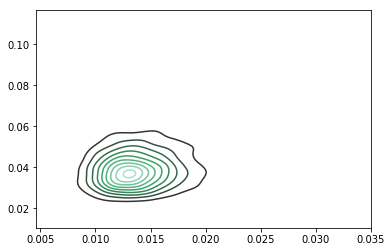

In [135]:
sns.kdeplot(ss[:,1], ss[:,0])
plt.show()

In [39]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [136]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [137]:
samples.shape

(3000, 20, 3, 4)

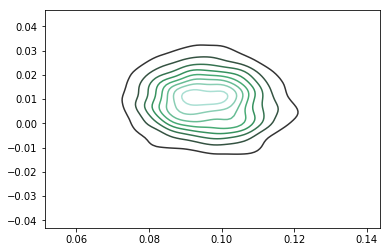

In [138]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [139]:
samples[:,10,2,0].mean()

0.09639029882481966

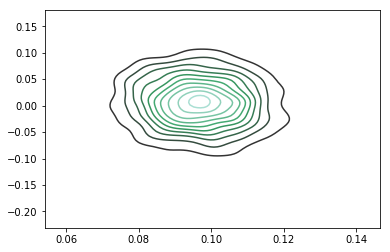

In [140]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [141]:
t = 10
# params[t]

In [142]:
np.mean(samples[:,t], axis=0)

array([[ 3.8452e-04, -2.7026e-02, -2.5439e-03,  8.9456e-03],
       [ 1.5068e-03,  3.8373e-03,  4.8605e-03,  1.4451e-04],
       [ 9.6390e-02, -6.9956e-04,  9.4577e-01, -3.3581e-04]])

In [143]:
np.std(samples[:,t], axis=0)

array([[0.0527, 0.024 , 0.0135, 0.0102],
       [0.0081, 0.0073, 0.0065, 0.0058],
       [0.0112, 0.004 , 0.0016, 0.0026]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


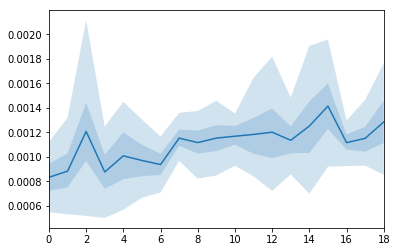

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


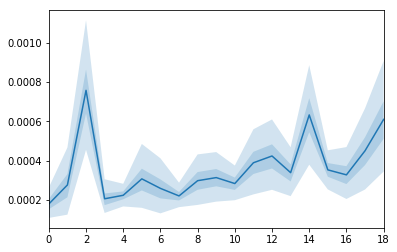

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


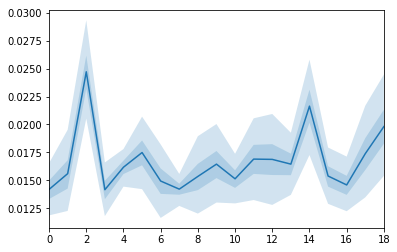

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()